# Integration of Motion

## Outline

[ ] Basic Euler
 - Throw a baseball
 - Compare with Truth
 - Show effect of timestep
 - Why timestep matters and error term
[ ] Verlet / Leapfrog
 - Comparison with previous baseball
 - Simple Pendulum
[ ] Runge Kutta

Starting with basic equation of motion, $ \vec{F} = m \vec{a} $

Where, using $\vec{r}$ as position, $\vec{v}$ for velocity, and $\vec{a}$ for acceleration of an object of mass $m$ experiencing the force $\vec{F}$, 
$$ \frac{d \vec{r}}{dt} = \vec{v} $$
$$  \quad \frac{d\vec{v}}{dt} = \vec{a} = \frac{1}{m} \vec{F} $$
If the force applied is only the downward force of gravity, ${F_g}_x = 0, {F_g}_y = -9.8 ~ (m / s^2)$ or more compactly $\vec{F}_g = \left[0, -9.8 \right] ~ (m / s^2)$

We can solve for the equations of motions to obtain the trajectory of a ball with initial position $\vec{r}_0$ and velocity $\vec{v}_0$ as,
$$\vec{r} (t) = \vec{r}_0 + \vec{v}_0 t - \frac{1}{2} g t^2 \hat{y}$$
Where g is the acceleration due to gravity of $(9.8 m / s^2)$.

To obtain a numerical method, we need a method for evaluating the derivatives $\frac{d\vec{r}}{dt}$ and $\frac{d\vec{v}}{dt}$ and obtain an equation of motion $\vec{r}(t)$.

Starting from the formal definition of the derivative with $\tau$ as an infitisemal time step.
$$ r'(t) = \lim_{\tau\to 0} \frac{r(t + \tau) - r(t)}{\tau} $$
However, for a given time $t$ and position $r(t)$, we must know the position at some small increment future time $r(t+\tau)$.
To find this new position, consider the taylor expansion of $r(t+\tau)$,
$$ r(t+\tau) = r(t) + \tau ~ r'(t) + \frac{\tau^2}{2} r''(t) + \cdots$$
The terms in the expansion involving second and higher order derivatives are equal to,
$$ \frac{\tau^2}{2} r''(t) + \cdots = \frac{\tau^2}{2} r''(\eta) $$
For some $\eta$ between $t$ and $t + \tau$.

Rearranging the taylor expansion for $r'(t)$ with this substitution, we have
$$ r'(t) = \frac{r(t + \tau) - r(t)}{\tau} - \frac{1}{2}\tau ~ r''(\eta) $$
Often written as,
$$ r'(t) = \frac{r(t + \tau) - r(t)}{\tau} + \mathcal{O}(\tau) $$
indicating that the additional term(s) are of order $\tau$ ($\tau$ raised to the one power).

In order to solve for $r(t + \tau)$, we must know make an approximation. In the _Euler_ method, we assume that the additional term(s) are zero. Now solving for $r(t+\tau)$ we finally have,
$$ r(t + \tau) = \tau ~ r'(t) + r(t) $$
and for $v(t)$ we have,
$$ v(t + \tau) = \tau ~ v'(t) + v(t) $$

Substituting the values of $r'(t) = v(t)$, $v'(t) = a(t)$
$$ r(t + \tau) = \tau ~ v(t) + r(t) $$
$$ v(t + \tau) = \tau ~ a(t) + v(t) $$

Using the notation of $t_n = n ~ \tau$ and $r_{n} = r(t_n)$, $r_{n+1} = r(t_{n+1}) = r(t_n + \tau)$,
$$ r_{n+1} = r_n + \tau ~v_n $$
$$ v_{n+1} = v_n + \tau ~a_n $$
Where $a_n = a(r_n, v_n)$.

Thus our method will be to 
1) Start with an initial position and velocity, $r_0$, $v_0$
2) Choose a time step $\tau$
3) Calculate $a_n = a(r_n, v_n)$
4) Use the update equations to calculate $v_{n+1}$ and $r_{n+1}$
5) Repeat steps 3 and 4 until we have reached a desired end point, either a time or some stopping condition

# Python Portion

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from dataclasses import dataclass


@dataclass
class Point2D:
    x: float = 0
    y: float = 0

    def __add__(self, other):
        temp = Point2D()
        if type(other) is Point2D:
            temp.x = self.x + other.x
            temp.y = self.y + other.y
            return temp
        elif type(other) is float:
            temp.x = self.x + other
            temp.y = self.y + other
            return temp

    def __radd__(self, other):
        return self.__add__(other)

    def __mul__(self, other):
        temp = Point2D()
        if type(other) is Point2D:
            temp.x = self.x * other.x
            temp.y = self.y * other.y
            return temp
        elif type(other) is float:
            temp.x = self.x * other
            temp.y = self.y * other
            return temp

    def __rmul__(self, other):
        return self.__mul__(other)
 

@dataclass
class PointObject:
    r: Point2D
    v: Point2D


@dataclass
class Ball(PointObject):
    time_step: float = 0

    def euler_update(self, a):
        new_v = self.v + self.time_step * a
        new_r = self.r + self.time_step * self.v

        self.v = new_v
        self.r = new_r


In [27]:
r_x = []
r_y = []

ball = Ball(r=Point2D(0, 0), v=Point2D(50, 50), time_step=0.1)
gravity = Point2D(0, -9.8)

while ball.r.y >= 0:
    r_x.append(ball.r.x)
    r_y.append(ball.r.y)
    
    ball.euler_update(gravity)

(0.0, 136.5546000000002)

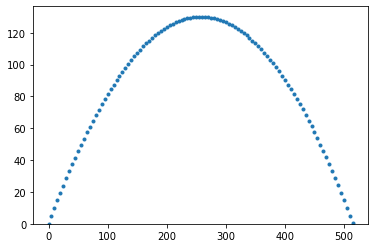

In [30]:
plt.plot(r_x, r_y, '.')
plt.ylim(0)